In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from datetime import datetime
import math

In [5]:
# ------------------ Fonctions utilitaires ------------------
def validate_ticker(default="AAPL"):
    """
    Valide le ticker de l'action en vérifiant qu'il contient des données.
    """
    while True:
        ticker = input(f"Entrez le ticker de l'action (par ex. AAPL, MSFT, TSLA) (par défaut : {default}) : ").strip().upper()
        ticker = ticker if ticker else default
        try:
            stock = yf.Ticker(ticker)
            prices = stock.history(period="1d")
            if prices.empty:
                print(f"Erreur : Le ticker '{ticker}' ne contient pas de données valides.")
                continue
            return ticker
        except Exception as e:
            print(f"Erreur : Impossible de valider le ticker '{ticker}'. Détails : {e}")

# Fonction pour calculer le prix Black-Scholes
def black_scholes_price(S, K, T, r, sigma, option_type):
    """
    Calcule le prix d'une option selon le modèle Black-Scholes.
    """
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if option_type.lower() == "call":
        return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'Call' or 'Put'.")

# Fonction pour calculer la volatilité implicite avec Black-Scholes
def implied_volatility(S, K, T, r, market_price, option_type):
    """
    Calcule la volatilité implicite à partir du modèle Black-Scholes.
    """
    def objective_function(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

    try:
        return brentq(objective_function, 1e-4, 5.0)  # Intervalle de recherche
    except ValueError:
        return float('nan')  # Retourne NaN si la volatilité ne peut pas être calculée

# Fonction pour calculer la volatilité implicite d'une option
def calculate_row_volatility(row, S, r, option_type):
    """
    Calcule la volatilité implicite pour une ligne donnée d'un DataFrame.
    """
    try:
        K = row['strike']  # Prix d'exercice
        T = (pd.to_datetime(row['expirationDate']) - pd.Timestamp.now()).days / 365  # Temps jusqu'à expiration
        market_price = row['lastPrice']  # Prix de marché
        return implied_volatility(S, K, T, r, market_price, option_type)
    except Exception as e:
        print(f"Erreur sur la ligne {row.name} : {e}")
        return float('nan')

# Fonction principale pour appliquer la volatilité implicite sur un DataFrame
def add_implied_volatility_to_df(options_df, S, r, option_type):
    """
    Ajoute la volatilité implicite à un DataFrame d'options.
    """
    options_df['calculatedImpliedVolatility'] = options_df.apply(
        lambda row: calculate_row_volatility(row, S, r, option_type), axis=1
    )
    return options_df

def plot_volatility_surface(dataset, option_type, current_price, ticker):
    """
    Génère un graphique 3D lissé de la surface de volatilité implicite.

    Paramètres :
        dataset (DataFrame): Le dataset contenant les colonnes 'strike', 'daysToExpiration', et 'calculatedImpliedVolatility'.
        option_type (str): Le type d'option, soit "Call" soit "Put".
        current_price (float): Le prix actuel du sous-jacent.
        ticker (str): Le ticker de l'action sous-jacente.

    Retour :
        None
    """
    # Préparer les données pour l'interpolation
    strikes = dataset['strike'].values
    days = dataset['daysToExpiration'].values
    volatilities = dataset['calculatedImpliedVolatility'].values

    # Créer une grille régulière
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(strikes), max(strikes), 100),
        np.linspace(min(days), max(days), 100)
    )

    # Interpoler les données pour lisser la surface
    grid_z = griddata(
        points=(strikes, days),
        values=volatilities,
        xi=(grid_x, grid_y),
        method='cubic'  # Méthode d'interpolation
    )

    # Créer la figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Tracer la surface 3D
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap='coolwarm',
        edgecolor='none',
        alpha=0.9
    )

    # Configurer les étiquettes et le titre
    ax.set_xlabel('Strike Price', labelpad=15)
    ax.set_ylabel('Days to Expiration', labelpad=15)
    ax.set_zlabel(f'Implied Volatility for {option_type} Options', labelpad=15)

    # Titre du graphique
    current_date = datetime.now().strftime('%b %d %Y @ %H:%M ET')
    ax.set_title(
        f"Implied Volatility Surface for {ticker.upper()} ({option_type} Options)\n"
        f"Current Price: {current_price:.2f} USD Date: {current_date}",
        pad=20
    )

    # Ajouter une barre de couleur
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

Dates d'expiration disponibles : ('2024-12-13', '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10', '2025-01-17', '2025-02-21', '2025-03-21', '2025-04-17', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15')

Données pour le tracé des Calls :
     strike  calculatedImpliedVolatility  daysToExpiration
0     175.0                     1.614908                 6
1     230.0                     0.335393                 6
2     225.0                     0.401645                 6
3     285.0                     0.481520                 6
4     217.5                     0.422577                 6
..      ...                          ...               ...
631    70.0                     0.585190               769
632   350.0                     0.238563               769
633   400.0                     0.233892               769
634   380.0                     0.234419               769
635   340.0                   

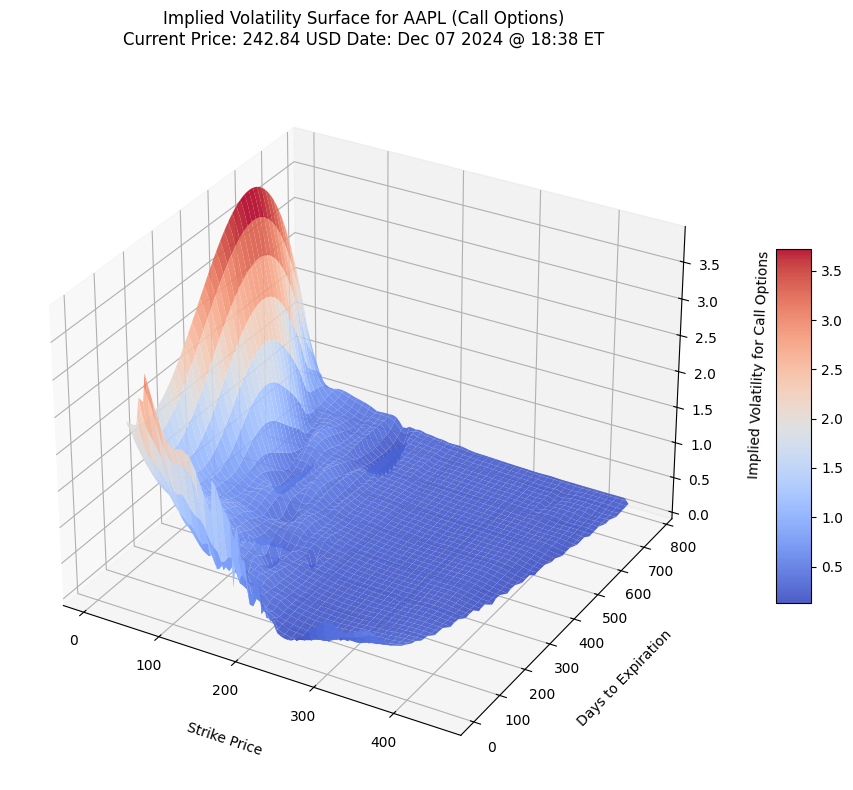

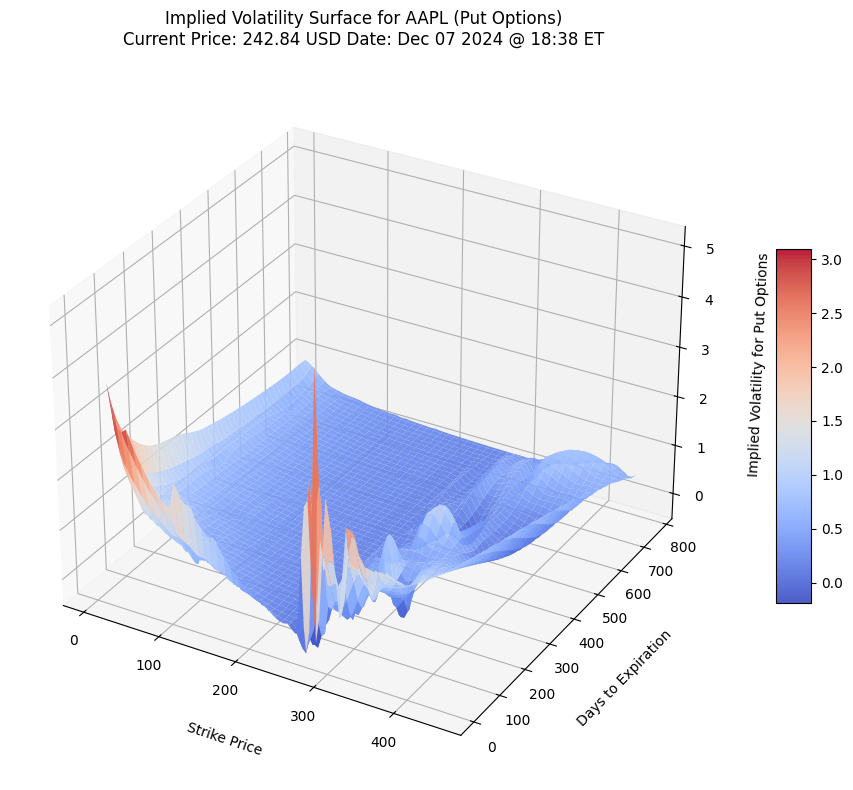

In [6]:
# ------------------ Code principal ------------------
if __name__ == "__main__":
    # Validation et récupération des données
    ticker = validate_ticker()
    stock = yf.Ticker(ticker)
    
    # Récupérer le prix actuel de l'action (sous-jacent)
    S = stock.history(period="1d")['Close'].iloc[-1]

    # Récupérer la date actuelle
    current_date = datetime.now().date()
    
    # Récupérer le taux sans risque   
    r = 0.02
    r = input("Entrez le taux sans risque (par défaut : 0.02) : ").strip() or r
    r = float(r)

    # Récupérer les dates d'expiration des options
    expiration_dates = stock.options
    print("Dates d'expiration disponibles :", expiration_dates)

    # Récupérer les données pour chaque date
    options_calls = []
    options_puts = []

    for date in expiration_dates:
        option_chain = stock.option_chain(date)
        calls = option_chain.calls
        puts = option_chain.puts

        # Ajouter des métadonnées aux options
        calls['type'] = 'Call'
        puts['type'] = 'Put'
        calls['expirationDate'] = date
        puts['expirationDate'] = date

        # Sélectionner un sous-ensemble aléatoire pour limiter la quantité de données
        calls = calls.sample(n=min(len(calls), 50))
        puts = puts.sample(n=min(len(puts), 50))

        options_calls.append(calls)
        options_puts.append(puts)

    # Concaténer les données séparément pour Calls et Puts
    calls_df = pd.concat(options_calls, ignore_index=True)
    puts_df = pd.concat(options_puts, ignore_index=True)

    # Calculer la volatilité implicite pour chaque option
    calls_with_volatility_calculated = add_implied_volatility_to_df(calls_df, S, r, "Call")
    puts_with_volatility_calculated = add_implied_volatility_to_df(puts_df, S, r, "Put")

    # Filtrer les colonnes nécessaires à la visualisation
    plot_call = calls_with_volatility_calculated[['strike', 'expirationDate', 'calculatedImpliedVolatility']].copy()
    plot_put = puts_with_volatility_calculated[['strike', 'expirationDate', 'calculatedImpliedVolatility']].copy()

    # Ajouter les jours jusqu'à expiration
    plot_call['daysToExpiration'] = plot_call['expirationDate'].apply(lambda x: (pd.to_datetime(x).date() - current_date).days)
    plot_put['daysToExpiration'] = plot_put['expirationDate'].apply(lambda x: (pd.to_datetime(x).date() - current_date).days)

    # Supprimer les colonnes 'expirationDate' pour le tracé
    plot_call.drop(columns=['expirationDate'], inplace=True)
    plot_put.drop(columns=['expirationDate'], inplace=True)

    # Supprimer les lignes avec des valeurs NaN
    plot_call.dropna(inplace=True)
    plot_put.dropna(inplace=True)

    # Reinitialiser l'index
    plot_call.reset_index(drop=True, inplace=True)
    plot_put.reset_index(drop=True, inplace=True)

    print("\nDonnées pour le tracé des Calls :")
    print(plot_call)

    print("\nDonnées pour le tracé des Puts :")
    print(plot_put)
    
    # Tracer la surface de volatilité implicite pour les Calls
    plot_volatility_surface(plot_call, "Call", S, ticker)

    # Tracer la surface de volatilité implicite pour les Puts
    plot_volatility_surface(plot_put, "Put", S, ticker)